<a href="https://colab.research.google.com/github/datascience-uniandes/linear-regression-tutorial/blob/master/forestfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PARCIAL 1

MINE-4101: Applied Data Science  
Universidad de los Andes  
  
Last update: September, 2022  
  
Dataset: Información de la inmobiliaria los Andes
Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/forest+fires)

**Código de Honor.**
Al entregar la solución de este parcial, yo, Fabián Camilo Castellanos Pinto con código 202226029 me comprometo a no conversar durante el desarrollo de este examen con ninguna persona que no sea el profesor del curso, sobre aspectos relacionados con el parcial; tampoco utilizaré algún medio de comunicación por voz, texto o intercambio de archivos, para consultar o compartir con otros, información sobre el tema del parcial. Soy consciente y acepto las consecuencias que acarreará para mi desempeño académico cometer fraude en este parcial

**Task:** Utilizar el mejor modelo obtenido para estimar la popularidad de los
inmuebles próximos a publicarse.

**Diccionario de datos:**
1. **id**:                      Identificador del inmueble
2. **neighbourhood group**:     Localidad o distrito en el que se encuentra el inmueble
3. **neighbourhood**:           Barrio en el que se encuentra el inmueble
4. **lat**, **long**:               Geolocalización del inmueble
5. **country**:                 Pais en el que se encuentra el inmueble
6. **instant bookable**:        Indicador de si es posible realizar reserva directamente en la plataforma
7. **cancellation_policy**:    Política de cancelación de la reserva
8. **room type**:              Tipo de inmueble
9. **construction year**:      Año de construcción del inmueble
10. **price**:                  Precio por noche del inmueble
11. **service fee**:            Costo del servicio el cual debe ser cancelado al dejar el inmueble
12. **minimum nights**:         Cantidad mí­nima de noches que el inmueble puede ser reservado
13. **availability 365**:       Disponibilidad total en días durante el último año
14. **number of reviews**:      Total de comentarios del inmueble
15. **review rate number**:     Calificación promedio dada al inmueble

In [336]:
!pip install --upgrade pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [337]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [338]:
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [339]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler  
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
import pylev
import math

### Leer y explorar las fuentes de datos

Cargo la información desde los archivos csv

In [340]:
nuevo_df = pd.read_csv('losalpes_new.csv', sep = ',')
historico_df = pd.read_csv('losalpes_history.csv', sep = ',')

Verifico la cantidad de filas y columnas históricas

In [341]:
historico_df.shape

(102083, 16)

Verifico los tipos de datos de la información histórica

In [342]:
historico_df.dtypes

id                       int64
neighbourhood group     object
neighbourhood           object
lat                    float64
long                   float64
country                 object
instant_bookable        object
cancellation_policy     object
room type               object
construction year      float64
price                   object
service fee             object
minimum nights         float64
availability 365       float64
number of reviews      float64
review rate number     float64
dtype: object

In [343]:
historico_df

,id,neighbourhood group,neighbourhood,lat,long,country,instant_bookable,cancellation_policy,room type,construction year,price,service fee,minimum nights,availability 365,number of reviews,review rate number
0,48540006,Manhattan,Hell's Kitchen,40.76212,-73.98820,United States,True,strict,Entire home/apt,2011.0,$ 851,$ 170,4.0,199.0,112.0,1.0
1,35079903,Manhattan,Midtown,40.74623,-73.98499,United States,True,flexible,Hotel room,2021.0,$ 466,$ 93,1.0,161.0,13.0,5.0
2,50681273,Manhattan,Upper West Side,40.78859,-73.97568,United States,False,flexible,Private room,2004.0,$ 874,$ 175,14.0,0.0,1.0,2.0
3,13039267,Manhattan,Financial District,40.70817,-74.00511,United States,False,strict,Private room,2012.0,$ 813,$ 163,1.0,0.0,5.0,3.0
4,8998640,Manhattan,Lower East Side,40.72130,-73.98900,United States,True,moderate,Entire home/apt,2007.0,$ 326,$ 65,4.0,301.0,9.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102078,4462048,Brooklyn,Prospect Heights,40.68137,-73.97081,United States,False,flexible,Entire home/apt,2014.0,$ 428,$ 86,3.0,142.0,27.0,2.0
102079,31315978,Brooklyn,Williamsburg,40.70951,-73.96443,United States,False,strict,Private room,2004.0,"$ 1,14",$ 227,2.0,343.0,7.0,2.0
102080,43430679,Queens,Rosedale,40.67104,-73.73006,United States,True,flexible,Private room,2018.0,$ 98,$ 20,2.0,355.0,12.0,1.0
102081,1476314,Manhattan,Upper West Side,40.78012,-73.98439,United States,True,moderate,Entire home/apt,2007.0,$ 316,$ 63,1.0,302.0,0.0,NaN


In [344]:
historico_df.head()

,id,neighbourhood group,neighbourhood,lat,long,country,instant_bookable,cancellation_policy,room type,construction year,price,service fee,minimum nights,availability 365,number of reviews,review rate number
0,48540006,Manhattan,Hell's Kitchen,40.76212,-73.98820,United States,True,strict,Entire home/apt,2011.0,$ 851,$ 170,4.0,199.0,112.0,1.0
1,35079903,Manhattan,Midtown,40.74623,-73.98499,United States,True,flexible,Hotel room,2021.0,$ 466,$ 93,1.0,161.0,13.0,5.0
2,50681273,Manhattan,Upper West Side,40.78859,-73.97568,United States,False,flexible,Private room,2004.0,$ 874,$ 175,14.0,0.0,1.0,2.0
3,13039267,Manhattan,Financial District,40.70817,-74.00511,United States,False,strict,Private room,2012.0,$ 813,$ 163,1.0,0.0,5.0,3.0
4,8998640,Manhattan,Lower East Side,40.72130,-73.98900,United States,True,moderate,Entire home/apt,2007.0,$ 326,$ 65,4.0,301.0,9.0,3.0


Verifico la cantidad de filas y columnas de los datos nuevos

In [345]:
nuevo_df.shape

(513, 14)

Verifico los tipos de datos de la información nueva

In [346]:
nuevo_df.dtypes

id                       int64
neighbourhood group     object
neighbourhood           object
lat                    float64
long                   float64
country                 object
instant_bookable        object
cancellation_policy     object
room type               object
construction year      float64
price                   object
service fee             object
minimum nights         float64
availability 365       float64
dtype: object

In [347]:
nuevo_df

,id,neighbourhood group,neighbourhood,lat,long,country,instant_bookable,cancellation_policy,room type,construction year,price,service fee,minimum nights,availability 365
0,27883434,Queens,Ozone Park,40.68432,-73.85862,United States,False,moderate,Private room,2006.0,$ 519,$ 104,1.0,NaN
1,55448727,Manhattan,Civic Center,40.71317,-74.00654,United States,False,moderate,Entire home/apt,2006.0,$ 987,$ 197,2.0,42.0
2,56858749,Queens,East Elmhurst,40.76441,-73.88943,NaN,True,flexible,Private room,2018.0,$ 999,$ 200,2.0,0.0
3,39029953,Manhattan,Gramercy,40.73442,-73.98383,United States,True,strict,Private room,2011.0,$ 497,$ 99,4.0,0.0
4,5567200,Manhattan,Upper West Side,40.79660,-73.97154,United States,True,strict,Entire home/apt,2022.0,$ 820,$ 164,4.0,376.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,14305691,Brooklyn,Bedford-Stuyvesant,40.69232,-73.93446,United States,False,moderate,Private room,2014.0,$ 103,$ 21,2.0,0.0
509,21955046,Brooklyn,Bedford-Stuyvesant,40.69122,-73.93753,United States,True,moderate,Private room,2008.0,$ 110,$ 22,2.0,21.0
510,35125192,Brooklyn,Williamsburg,40.71896,-73.94270,United States,False,strict,Entire home/apt,2022.0,$ 251,$ 50,30.0,335.0
511,46665500,Brooklyn,Fort Greene,40.68531,-73.97451,United States,True,strict,Private room,2022.0,"$ 1,01",$ 201,1.0,41.0


In [348]:
nuevo_df.head()

,id,neighbourhood group,neighbourhood,lat,long,country,instant_bookable,cancellation_policy,room type,construction year,price,service fee,minimum nights,availability 365
0,27883434,Queens,Ozone Park,40.68432,-73.85862,United States,False,moderate,Private room,2006.0,$ 519,$ 104,1.0,NaN
1,55448727,Manhattan,Civic Center,40.71317,-74.00654,United States,False,moderate,Entire home/apt,2006.0,$ 987,$ 197,2.0,42.0
2,56858749,Queens,East Elmhurst,40.76441,-73.88943,NaN,True,flexible,Private room,2018.0,$ 999,$ 200,2.0,0.0
3,39029953,Manhattan,Gramercy,40.73442,-73.98383,United States,True,strict,Private room,2011.0,$ 497,$ 99,4.0,0.0
4,5567200,Manhattan,Upper West Side,40.79660,-73.97154,United States,True,strict,Entire home/apt,2022.0,$ 820,$ 164,4.0,376.0


Verificando los datos mediante profile

In [349]:
profile_hist = ProfileReport(historico_df)

In [350]:
#profile_hist.to_notebook_iframe()

In [351]:
profile_nuevo = ProfileReport(nuevo_df)

In [352]:
#profile_nuevo.to_notebook_iframe()

Generando copia de la información para mantener el original por separado

In [353]:
historico_limpio_df = historico_df

Las columnas que inicialmente serán tenidas en cuenta

In [354]:
columnas_h = ['neighbourhood group', 'neighbourhood', 'lat', 'long', 'country', 'instant_bookable', 'cancellation_policy', 'room type',
'construction year', 'price', 'service fee', 'minimum nights', 'availability 365', 'number of reviews', 'review rate number']

Total de los datos iniciales para el histórico

In [355]:
num_historico_inicio = historico_limpio_df.shape[0]
print("La información histórica inicial tiene {} registro(s)".format(num_historico_inicio))

La información histórica inicial tiene 102083 registro(s)


Reviso los valores duplicados

In [356]:
a = historico_limpio_df.drop_duplicates(keep="last")
num_historico_inicio
print("La información histórica inicial tiene {} registro(s) nulos".format(num_historico_inicio - a.shape[0]))

La información histórica inicial tiene 536 registro(s) nulos


In [357]:
#num_duplicado_h = historico_limpio_df.duplicated(columnas_h).shape[0]
num_duplicado_h = historico_limpio_df.duplicated(subset="id").shape[0]
print("La información histórica tiene {} registro(s) nulos que deben ser borrados".format(num_duplicado_h))
#historico_limpio_df

La información histórica tiene 102083 registro(s) nulos que deben ser borrados


Reviso las coordenadas

La información sin coordenadas será borrada

In [358]:
num_duplicado_y_h = historico_limpio_df.loc[historico_limpio_df["lat"].apply(lambda x: pd.isnull(x))].shape[0]
print("La información histórica tiene {} registro(s) nulos de coordenada latitud (Y) que deben ser borrados".format(num_duplicado_y_h))

La información histórica tiene 599 registro(s) nulos de coordenada latitud (Y) que deben ser borrados


In [359]:
num_duplicado_x_h = historico_limpio_df.loc[historico_limpio_df["long"].apply(lambda x: pd.isnull(x))].shape[0]
print("La información histórica tiene {} registro(s) nulos de coordenada longitud (X) que deben ser borrados".format(num_duplicado_x_h))

La información histórica tiene 599 registro(s) nulos de coordenada longitud (X) que deben ser borrados


Reviso los valores únicos de las columnas para los distritos

In [360]:
num_duplicado_dist_h = historico_limpio_df.loc[historico_limpio_df["neighbourhood group"].apply(lambda x: pd.isnull(x))].shape[0]
print("La información histórica tiene {} registro(s) nulos que deben ser borrados".format(num_duplicado_dist_h))

La información histórica tiene 620 registro(s) nulos que deben ser borrados


Reviso la cantidad de registros nulos de los distritos


In [361]:
num_duplicado_dist_h = historico_limpio_df.loc[historico_limpio_df["neighbourhood group"].apply(lambda x: pd.isnull(x))].shape[0]
print("La información histórica tiene {} registro(s) nulos de distrito que deben ser borrados".format(num_duplicado_dist_h))

La información histórica tiene 620 registro(s) nulos de distrito que deben ser borrados


Reviso las cantidades para los valores de los distritos en ambos datasets

In [362]:
historico_limpio_df["neighbourhood group"].value_counts()

Manhattan        43384
Brooklyn         41437
Queens           13015
Bronx             2666
Staten Island      943
Broolkyn             7
Quens                4
Manhatan             4
Manattan             1
brookln              1
manhatan             1
Name: neighbourhood group, dtype: int64

In [363]:
nuevo_df["neighbourhood group"].value_counts()

Manhattan        224
Brooklyn         199
Queens            71
Bronx             14
Staten Island      4
Name: neighbourhood group, dtype: int64

Reviso la cantidad de registros nulos de los distritos

In [364]:
num_duplicado_barrio_h = historico_limpio_df.loc[historico_limpio_df["neighbourhood"].apply(lambda x: pd.isnull(x))].shape[0]
print("La información histórica tiene {} registro(s) nulos de distrito que deben ser borrados".format(num_duplicado_barrio_h))

La información histórica tiene 607 registro(s) nulos de distrito que deben ser borrados


Reviso los valores únicos de las columnas de los 2 datasets para los barrios

In [365]:
historico_limpio_df["neighbourhood"].value_counts()

Bedford-Stuyvesant        7857
Williamsburg              7720
Harlem                    5400
Bushwick                  4930
Hell's Kitchen            3927
                          ... 
Lighthouse Hill              3
Gerritsen Beach              3
Glen Oaks                    2
Fort Wadsworth               2
Chelsea, Staten Island       1
Name: neighbourhood, Length: 224, dtype: int64

In [366]:
nuevo_df["neighbourhood"].value_counts()

Bedford-Stuyvesant    41
Williamsburg          38
Harlem                29
Hell's Kitchen        21
Bushwick              21
                      ..
Kensington             1
Huguenot               1
Bensonhurst            1
Carroll Gardens        1
Van Nest               1
Name: neighbourhood, Length: 94, dtype: int64

Reviso los valores únicos de las columnas de los 2 datasets para el país

In [367]:
num_pais_h_nulo = historico_limpio_df["country"].loc[historico_limpio_df["country"].isnull()].count()
print("La información tiene {} registro(s) con país(es) nulo(s)".format(num_pais_h_nulo))

La información tiene 0 registro(s) con país(es) nulo(s)


In [368]:
historico_limpio_df["country"].value_counts()

United States               100957
United States of America        10
Name: country, dtype: int64

In [369]:
nuevo_df["country"].value_counts()

United States    507
Name: country, dtype: int64

Reviso los valores únicos de las columnas de los 2 datasets para el costo del servicio

In [370]:
num_costo_h_nulo = historico_limpio_df["country"].loc[historico_limpio_df["country"].isnull()].count()
print("La información tiene {} registro(s) con país(es) nulo(s)".format(num_costo_h_nulo))

La información tiene 0 registro(s) con país(es) nulo(s)


In [371]:
historico_limpio_df["service fee"].value_counts()

$ 216       519
$ 177       517
$ 41        517
$ 81        514
$ 57        506
           ... 
$ 58        376
$ 10        262
$ 240       247
$ 122000      1
$ -193        1
Name: service fee, Length: 233, dtype: int64

In [372]:
nuevo_df["service fee"].value_counts()

$ 139    7
$ 214    6
$ 164    6
$ 15     5
$ 238    5
        ..
$ 24     1
$ 121    1
$ 91     1
$ 143    1
$ 22     1
Name: service fee, Length: 203, dtype: int64

Reviso los valores únicos de las columnas de los 2 datasets para el tipo de habitación

In [373]:
num_tipohab_h_nulo = historico_limpio_df["room type"].loc[historico_limpio_df["room type"].isnull()].count()
print("La información tiene {} registro(s) con tipo de habitación nulo(s)".format(num_tipohab_h_nulo))

La información tiene 0 registro(s) con tipo de habitación nulo(s)


In [374]:
historico_limpio_df["room type"].value_counts()

Entire home/apt    53183
Private room       46011
Shared room         2184
Hotel room           114
Name: room type, dtype: int64

In [375]:
nuevo_df["room type"].value_counts()

Entire home/apt    263
Private room       237
Shared room         10
Hotel room           2
Name: room type, dtype: int64

Reviso los valores únicos de las columnas de los 2 datasets para el año de construcción

In [376]:
historico_limpio_df["construction year"].value_counts()

2014.0    5185
2008.0    5182
2006.0    5176
2019.0    5148
2020.0    5111
2010.0    5107
2009.0    5099
2005.0    5084
2022.0    5071
2012.0    5070
2003.0    5059
2007.0    5054
2015.0    5027
2011.0    5009
2018.0    5003
2017.0    5003
2021.0    4997
2016.0    4967
2004.0    4965
2013.0    4959
1022.0       2
1020.0       1
Name: construction year, dtype: int64

In [377]:
nuevo_df["construction year"].value_counts()

2015.0    38
2004.0    33
2022.0    31
2012.0    31
2014.0    30
2003.0    29
2016.0    27
2018.0    27
2019.0    26
2006.0    25
2009.0    25
2011.0    25
2013.0    24
2020.0    24
2007.0    23
2017.0    23
2008.0    20
2021.0    19
2010.0    18
2005.0    14
Name: construction year, dtype: int64

Reviso la calificación promedio

In [378]:
num_califica_prom_h_nulo = historico_limpio_df["review rate number"].loc[historico_limpio_df["review rate number"].isnull()].count()
print("La información tiene {} registro(s) con calificaciones nula(s)".format(num_califica_prom_h_nulo))

La información tiene 0 registro(s) con calificaciones nula(s)


###Limpieza de datos en la información histórica

Borro la información de los duplicados

In [379]:
historico_limpio_df = historico_limpio_df.drop_duplicates(keep="last")
print("La información histórica tiene ahora {} registro(s)".format(historico_limpio_df.shape[0]))

La información histórica tiene ahora 101547 registro(s)


Borrado de la información duplicada sin tener en cuenta el identificador

In [380]:
num_duplicado_h = historico_limpio_df.duplicated(columnas_h).shape[0]
print("La información histórica tiene {} registro(s) nulos que serán borrados".format(num_duplicado_h))

historico_limpio_df = historico_limpio_df.drop_duplicates(subset=columnas_h, keep='first')
print("La información histórica tiene ahora {} registro(s)".format(historico_limpio_df.shape[0]))

La información histórica tiene 101547 registro(s) nulos que serán borrados
La información histórica tiene ahora 95054 registro(s)


In [381]:
nuevo_dup_df = nuevo_df[nuevo_df.duplicated()]

In [382]:
def tiene_duplicados(reg):
  res = 'no hay duplicado'
  if(reg > 0):
    res = 'tienen {} duplicado(s)'.format(reg)
  return res

print("Los datos históricos {}".format(tiene_duplicados(historico_limpio_df.shape[0])))
print("Los datos nuevos {}".format(tiene_duplicados(nuevo_df.shape[0])))

Los datos históricos tienen 95054 duplicado(s)
Los datos nuevos tienen 513 duplicado(s)


Borro los datos históricos duplicados

In [383]:
#historico_limpio_df = historico_limpio_df.drop_duplicates()

Borrado de la información sin coordenadas

In [384]:
historico_limpio_df.drop(historico_limpio_df.loc[historico_limpio_df["lat"].apply(lambda x: pd.isnull(x))].index, inplace=True)
historico_limpio_df.drop(historico_limpio_df.loc[historico_limpio_df["long"].apply(lambda x: pd.isnull(x))].index, inplace=True)
print("La información histórica tiene ahora {} registro(s)".format(historico_limpio_df.shape[0]))

La información histórica tiene ahora 95045 registro(s)


Borrado de la información sin distrito

In [385]:
historico_limpio_df.drop(historico_limpio_df.loc[historico_limpio_df["neighbourhood group"].apply(lambda x: pd.isnull(x))].index, inplace=True)
print("La información histórica tiene ahora {} registro(s)".format(historico_limpio_df.shape[0]))

La información histórica tiene ahora 95016 registro(s)


Ajuste de los valores de precio para eliminar el símbolo y los valores negativos llevados a valor positivo

In [446]:
# Reemplazar simbolos
def arregla_dinero(x):
    x = str(x).replace('$', '').replace(",", ".").lstrip()
    return abs(float(x))

historico_limpio_df['service fee'] = historico_limpio_df['service fee'].apply(arregla_dinero)
historico_limpio_df['price'] = historico_limpio_df['price'].apply(arregla_dinero)
nuevo_df['service fee'] = nuevo_df['service fee'].apply(arregla_dinero)
nuevo_df['service fee'] = nuevo_df['service fee'].apply(arregla_dinero)

In [436]:
historico_limpio_df['service fee'].describe(percentiles = [.25, .5, .75, .95, .99])

count     94744.000000
mean        126.241482
std         401.467843
min          10.000000
25%          68.000000
50%         125.000000
75%         182.000000
95%         229.000000
99%         238.000000
max      122000.000000
Name: service fee, dtype: float64

In [388]:
historico_limpio_df.dtypes

id                       int64
neighbourhood group     object
neighbourhood           object
lat                    float64
long                   float64
country                 object
instant_bookable        object
cancellation_policy     object
room type               object
construction year      float64
price                  float64
service fee            float64
minimum nights         float64
availability 365       float64
number of reviews      float64
review rate number     float64
dtype: object

In [389]:
nuevo_df.dtypes

id                       int64
neighbourhood group     object
neighbourhood           object
lat                    float64
long                   float64
country                 object
instant_bookable        object
cancellation_policy     object
room type               object
construction year      float64
price                   object
service fee            float64
minimum nights         float64
availability 365       float64
dtype: object

Borrado de datos sin información

In [473]:
historico_limpio_df.drop(historico_limpio_df.loc[historico_limpio_df["availability 365"].apply(lambda x: pd.isnull(x))].index, inplace=True)
print("La información histórica tiene ahora {} registro(s)".format(historico_limpio_df.shape[0]))

La información histórica tiene ahora 94584 registro(s)


In [474]:
historico_limpio_df.drop(historico_limpio_df.loc[historico_limpio_df["minimum nights"].apply(lambda x: pd.isnull(x))].index, inplace=True)
print("La información histórica tiene ahora {} registro(s)".format(historico_limpio_df.shape[0]))

La información histórica tiene ahora 94215 registro(s)


Ajustando los valores de ortografía

In [390]:
neigh_group_list = ["Manhattan","Brooklyn","Queens","Bronx","Staten Island"]


def arregla_grupo(d):
  distance = 10
  index = -1
  res = d
  for n in neigh_group_list:
    try:
      new_distance = pylev.levenshtein(n, d)
      if(new_distance < distance):
        distance = new_distance
        index = neigh_group_list.index(n)
    except:
      pass

  if(index > -1):
    res = neigh_group_list[index]

  return res
  
historico_limpio_df["neighbourhood group"] = historico_limpio_df["neighbourhood group"].apply(arregla_grupo)
nuevo_df["neighbourhood group"] = nuevo_df["neighbourhood group"].apply(arregla_grupo)

In [391]:
historico_limpio_df["neighbourhood group"].value_counts()

Manhattan        40676
Brooklyn         38750
Queens           12226
Bronx             2492
Staten Island      872
Name: neighbourhood group, dtype: int64

In [392]:
nuevo_df["neighbourhood group"].value_counts()

Manhattan        224
Brooklyn         199
Queens            71
Bronx             14
Staten Island      4
Name: neighbourhood group, dtype: int64

Ajuste de los valores de país

In [439]:
historico_limpio_df = historico_limpio_df.replace({ 'country': {'United States of America': 'United States'} })
historico_limpio_df["country"].value_counts()

United States    94492
Name: country, dtype: int64

Ajustando los valores de los años de construcción

In [394]:
historico_limpio_df = historico_limpio_df.replace({ 'construction year': {1022: 2022, 1020: 2020} })

In [395]:
historico_limpio_df["construction year"].value_counts()

2008.0    4862
2014.0    4846
2006.0    4820
2020.0    4803
2019.0    4796
2010.0    4780
2009.0    4779
2003.0    4764
2007.0    4752
2005.0    4749
2022.0    4743
2015.0    4723
2012.0    4716
2011.0    4695
2017.0    4687
2018.0    4681
2021.0    4675
2016.0    4656
2004.0    4642
2013.0    4640
Name: construction year, dtype: int64

Transformando los datos para la posibilidad de realizar una reserva en la plataforma directamente

In [477]:
def ajusta_reserva(fila):
  if(str(fila) != None):
    if(fila):
      return 1
    else:
      return 0
  else:
    return -1

historico_limpio_df["instant_bookable"] = historico_limpio_df["instant_bookable"].apply(ajusta_reserva)
historico_limpio_df['service fee'].describe(percentiles = [.25, .5, .75, .95, .99])

count     93943.000000
mean        126.262830
std         403.130154
min          10.000000
25%          68.000000
50%         125.000000
75%         182.000000
95%         229.000000
99%         238.000000
max      122000.000000
Name: service fee, dtype: float64

In [398]:
historico_limpio_df.dtypes

id                       int64
neighbourhood group     object
neighbourhood           object
lat                    float64
long                   float64
country                 object
instant_bookable       float64
cancellation_policy     object
room type               object
construction year      float64
price                  float64
service fee            float64
minimum nights         float64
availability 365       float64
number of reviews      float64
review rate number     float64
dtype: object

El proceso de limpieza ha finalizado, verifiquemos las columnas de cada dataset

In [399]:
historico_limpio_df.dtypes

id                       int64
neighbourhood group     object
neighbourhood           object
lat                    float64
long                   float64
country                 object
instant_bookable       float64
cancellation_policy     object
room type               object
construction year      float64
price                  float64
service fee            float64
minimum nights         float64
availability 365       float64
number of reviews      float64
review rate number     float64
dtype: object

In [400]:
nuevo_df.dtypes

id                       int64
neighbourhood group     object
neighbourhood           object
lat                    float64
long                   float64
country                 object
instant_bookable        object
cancellation_policy     object
room type               object
construction year      float64
price                   object
service fee            float64
minimum nights         float64
availability 365       float64
dtype: object

Ajustes para los valores positivos

In [479]:
def arregla_negativo(x):  
  return abs(x)

historico_limpio_df["availability 365"] = historico_limpio_df["availability 365"].apply(arregla_negativo)
historico_limpio_df["minimum nights"] = historico_limpio_df["minimum nights"].apply(arregla_negativo)

In [480]:
historico_limpio_df['availability 365'].describe(percentiles = [.25, .5, .75, .95, .99])

count    94215.000000
mean       142.921796
std        135.576897
min          0.000000
25%          5.000000
50%        101.000000
75%        270.000000
95%        365.000000
99%        404.860000
max       3677.000000
Name: availability 365, dtype: float64

In [481]:
historico_limpio_df['minimum nights'].describe(percentiles = [.25, .5, .75, .95, .99])

count    94215.000000
mean         8.241310
std         29.362058
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
95%         30.000000
99%         56.860000
max       5645.000000
Name: minimum nights, dtype: float64

#Análisis del objetivo

In [482]:
historico_limpio_df['number of reviews'].describe(percentiles = [.25, .5, .75, .95, .99])

count    94097.000000
mean        27.490961
std         49.726950
min          0.000000
25%          1.000000
50%          7.000000
75%         30.000000
95%        125.000000
99%        233.000000
max       1024.000000
Name: number of reviews, dtype: float64

In [402]:
print("El promedio de la variable objetivo es: {}".format(historico_limpio_df['number of reviews'].mean()))

El promedio de la variable objetivo es: 27.569136036776957


In [403]:
print("La desviación estándar de la variable objetivo es: {}".format(historico_limpio_df['number of reviews'].std()))

La desviación estándar de la variable objetivo es: 50.019281525424994


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


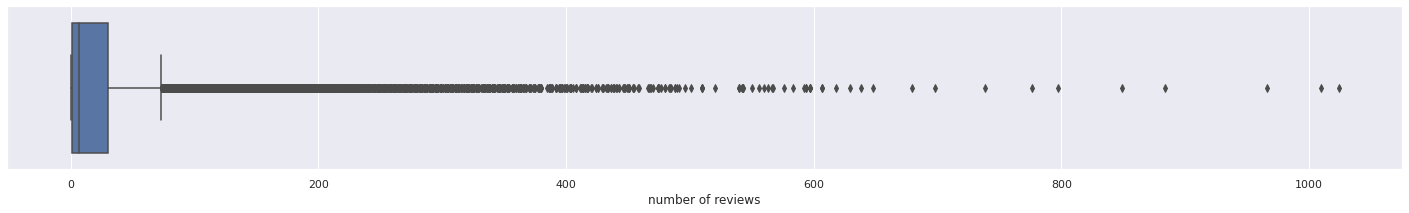

In [404]:
sns.set(rc={'figure.figsize':(30,12)}) 
plt.figure(figsize = (25, 3))
sns.boxplot(historico_limpio_df['number of reviews'])
plt.show()

In [483]:
historico_sel_df = historico_limpio_df.loc[historico_limpio_df['number of reviews'] <= historico_limpio_df['number of reviews'].quantile(.95)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


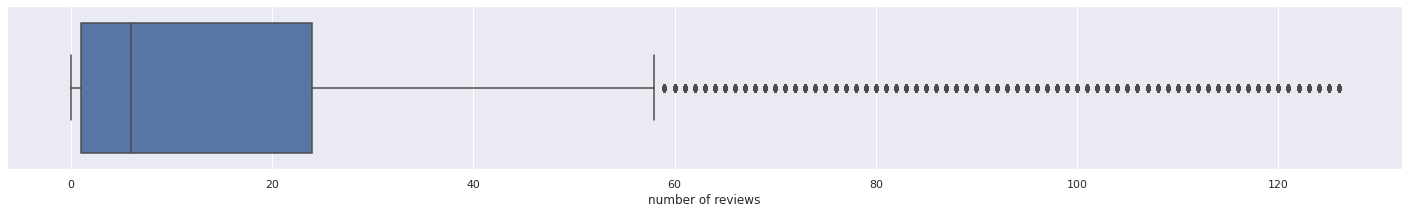

In [442]:
sns.set(rc={'figure.figsize':(25,12)}) 
plt.figure(figsize = (25, 3))
sns.boxplot(historico_sel_df['number of reviews'])
plt.show()

En este instante podemos ver un mejor set de datos sin los datos atípicos de las calificaciones

# **Elementos para entrenamiento del modelo**

Seleccionando la variables

In [406]:
variables = ['lat','long', 'construction year','price','service fee','minimum nights', 'availability 365','review rate number']

In [484]:
nuevo_duplicado_h_df = historico_limpio_df[historico_limpio_df.duplicated(['lat','long', 'construction year','price','service fee','minimum nights', 'availability 365','review rate number', 'number of reviews'])]
nuevo_duplicado_h_df.shape[0]

22360

In [485]:
print("El dataset cuenta con {} registro(s)".format(historico_sel_df.shape[0]))
for variable in variables:
  print(variable)
  max = historico_sel_df[variable].max()
  min = historico_sel_df[variable].min()
  nulos = historico_sel_df[variable].loc[historico_sel_df[variable].isnull()].count()
  print("La variable '{}' tiene como valor mínimo: {}, valor máximo: {}, valores nulos: {}".format(variable, min, max, nulos))

El dataset cuenta con 89393 registro(s)
lat
La variable 'lat' tiene como valor mínimo: 40.49979, valor máximo: 40.91697, valores nulos: 0
long
La variable 'long' tiene como valor mínimo: -74.24984, valor máximo: -73.70522, valores nulos: 0
construction year
La variable 'construction year' tiene como valor mínimo: 2003.0, valor máximo: 2022.0, valores nulos: 0
price
La variable 'price' tiene como valor mínimo: 1.0, valor máximo: 254000.0, valores nulos: 0
service fee
La variable 'service fee' tiene como valor mínimo: 10.0, valor máximo: 122000.0, valores nulos: 0
minimum nights
La variable 'minimum nights' tiene como valor mínimo: 1.0, valor máximo: 5645.0, valores nulos: 0
availability 365
La variable 'availability 365' tiene como valor mínimo: 0.0, valor máximo: 426.0, valores nulos: 0
review rate number
La variable 'review rate number' tiene como valor mínimo: 1.0, valor máximo: 5.0, valores nulos: 0


In [486]:
corr = historico_sel_df[variables + ['number of reviews']].corr()

Visualizacion de correlación usando la matriz de Pearson (incluyendo un mapa de calor)

<AxesSubplot:>

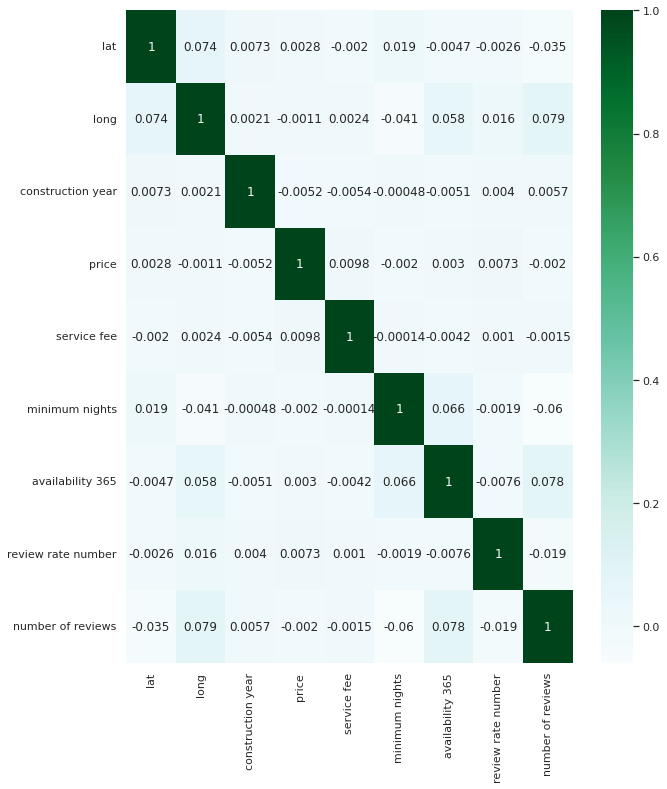

In [487]:
sns.set(rc={'figure.figsize':(10,12)}) 
sns.heatmap(corr, annot = True, cmap="BuGn")

In [488]:
X = historico_sel_df[variables]

In [489]:
X

,lat,long,construction year,price,service fee,minimum nights,availability 365,review rate number
0,40.76212,-73.98820,2011.0,851.00,170.0,4.0,199.0,1.0
1,40.74623,-73.98499,2021.0,466.00,93.0,1.0,161.0,5.0
2,40.78859,-73.97568,2004.0,874.00,175.0,14.0,0.0,2.0
3,40.70817,-74.00511,2012.0,813.00,163.0,1.0,0.0,3.0
4,40.72130,-73.98900,2007.0,326.00,65.0,4.0,301.0,3.0
...,...,...,...,...,...,...,...,...
102078,40.68137,-73.97081,2014.0,428.00,86.0,3.0,142.0,2.0
102079,40.70951,-73.96443,2004.0,1.14,227.0,2.0,343.0,2.0
102080,40.67104,-73.73006,2018.0,98.00,20.0,2.0,355.0,1.0
102081,40.78012,-73.98439,2007.0,316.00,63.0,1.0,302.0,NaN


In [490]:
Y = historico_sel_df['number of reviews']

In [462]:
Y

0         112.0
1          13.0
2           1.0
3           5.0
4           9.0
          ...  
102078     27.0
102079      7.0
102080     12.0
102081      0.0
102082      1.0
Name: number of reviews, Length: 90139, dtype: float64

Particionando los datos

In [491]:
X_entrena, X_prueba, Y_entrena, Y_prueba = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [492]:
X_entrena

,lat,long,construction year,price,service fee,minimum nights,availability 365,review rate number
6269,40.71921,-73.99238,2006.0,407.00,81.0,3.0,59.0,5.0
94101,40.68186,-73.92173,2009.0,1.01,202.0,2.0,0.0,1.0
1984,40.73268,-73.98689,2007.0,57.00,11.0,30.0,347.0,4.0
68776,40.66461,-73.99506,2009.0,559.00,112.0,15.0,0.0,5.0
10808,40.71586,-73.98908,2021.0,133.00,27.0,4.0,56.0,4.0
...,...,...,...,...,...,...,...,...
23389,40.72099,-73.96007,2014.0,403.00,81.0,1.0,0.0,3.0
82882,40.72488,-73.98317,2010.0,681.00,136.0,2.0,6.0,3.0
55675,40.76087,-73.88375,2008.0,400.00,80.0,3.0,0.0,4.0
5596,40.70422,-73.91405,2004.0,57.00,11.0,5.0,204.0,4.0


In [493]:
X_prueba

,lat,long,construction year,price,service fee,minimum nights,availability 365,review rate number
9105,40.70600,-74.00770,2014.0,84.00,17.0,4.0,0.0,2.0
47271,40.73352,-73.98730,2014.0,1.02,203.0,2.0,242.0,1.0
68246,40.73565,-73.89511,2014.0,664.00,133.0,1.0,88.0,2.0
94849,40.63863,-74.01916,2004.0,372.00,74.0,14.0,0.0,4.0
83316,40.72818,-73.99993,2019.0,838.00,168.0,5.0,45.0,5.0
...,...,...,...,...,...,...,...,...
62017,40.69563,-73.93206,2005.0,287.00,57.0,4.0,0.0,4.0
13421,40.74639,-73.94350,2010.0,362.00,72.0,2.0,23.0,3.0
44473,40.72411,-73.94182,2005.0,1.04,207.0,2.0,0.0,3.0
85731,40.80131,-73.96596,2003.0,1.06,212.0,50.0,1.0,4.0


In [494]:
Y_entrena

6269     77.0
94101     0.0
1984      7.0
68776     1.0
10808    16.0
         ... 
23389    12.0
82882     1.0
55675    19.0
5596      1.0
88069     0.0
Name: number of reviews, Length: 71514, dtype: float64

In [495]:
Y_prueba

9105       6.0
47271     87.0
68246     12.0
94849      1.0
83316     11.0
          ... 
62017      1.0
13421      0.0
44473     21.0
85731      0.0
100474     4.0
Name: number of reviews, Length: 17879, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


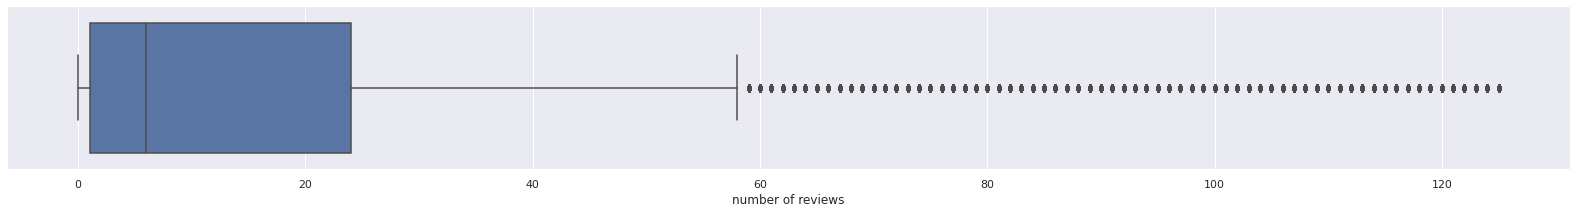

In [496]:
plt.figure(figsize = (28, 3))
sns.boxplot(Y_entrena)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


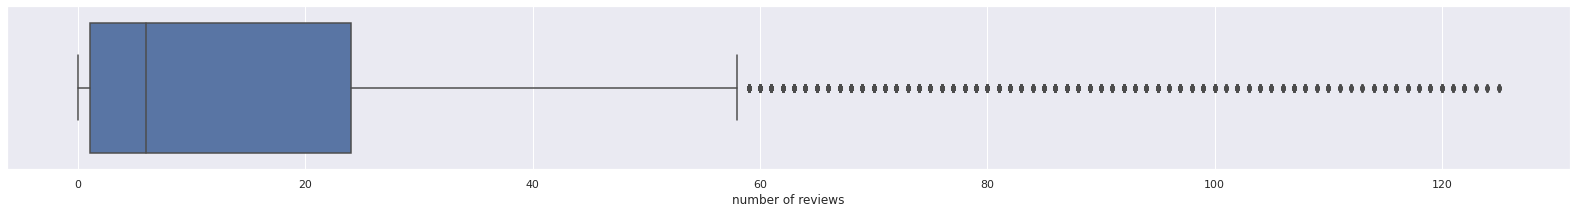

In [497]:
plt.figure(figsize = (28, 3))
sns.boxplot(Y_prueba)
plt.show()

Revisamos la visualización gráfica para los datos de entrenamiento

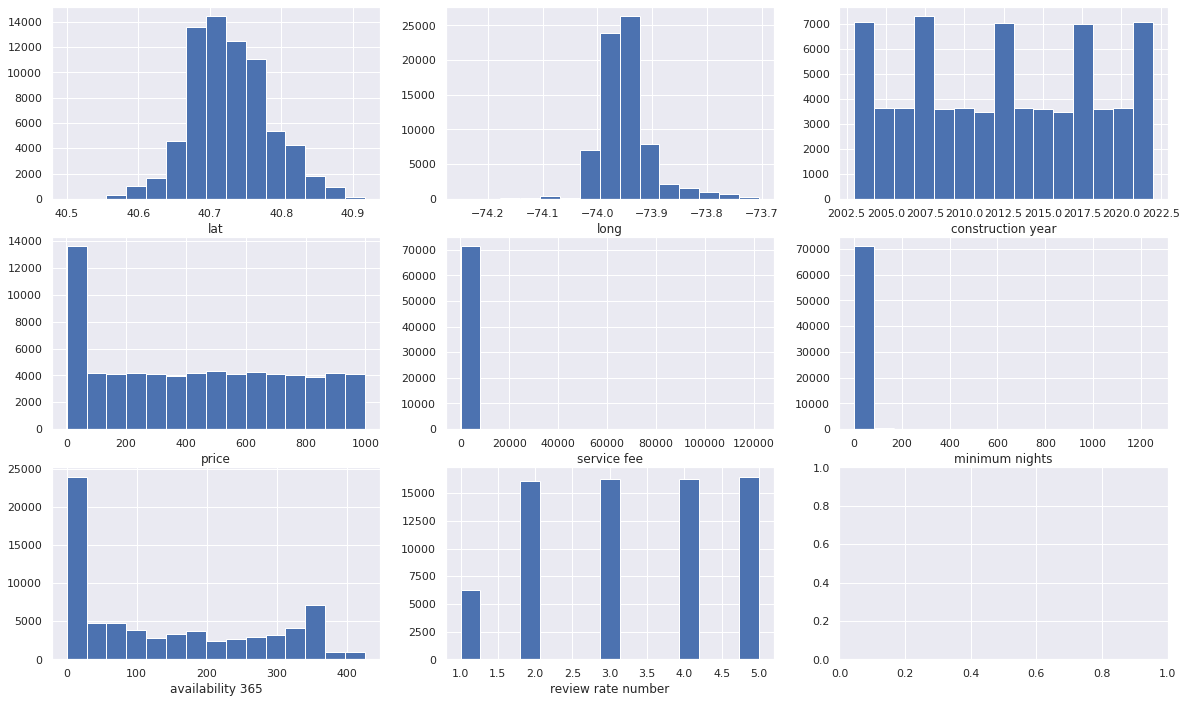

In [498]:
sns.set(rc={'figure.figsize':(20,12)}) 
fix, axes = plt.subplots(3, 3)
for k in range(0, len(variables)):
  plt.subplot(3,3, k + 1)
  plt.hist(X_entrena[X_entrena.columns[k]], bins=15)
  plt.xlabel(X_entrena.columns[k])
plt.show()

Text(0.5, 0, 'number of reviews')

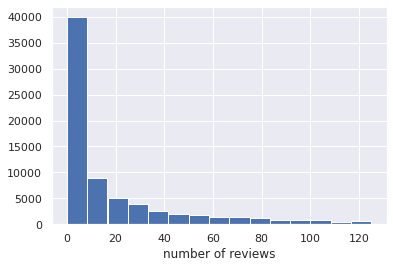

In [499]:
sns.set(rc={'figure.figsize':(6,4)}) 
plt.hist(Y_entrena, bins=15)
plt.xlabel("number of reviews")

Revisamos la visualización gráfica para los datos de prueba

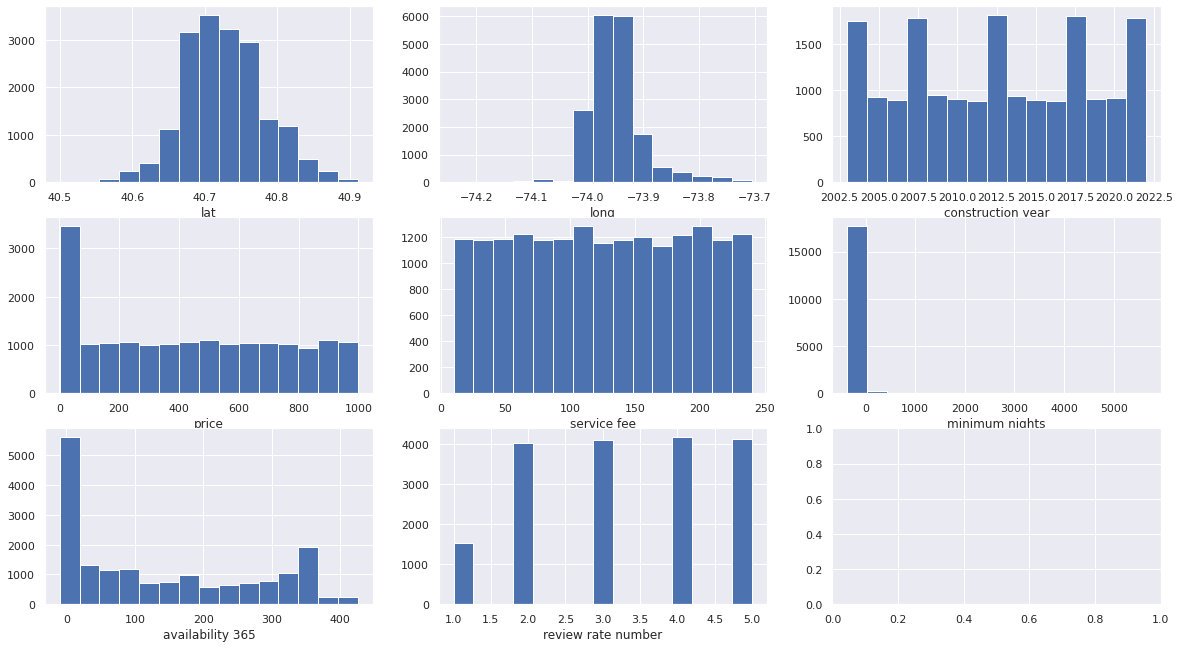

In [425]:
sns.set(rc={'figure.figsize':(20,11)}) 
fix, axes = plt.subplots(3, 3)
for k in range(0, len(variables)):
  plt.subplot(3, 3, k + 1)
  plt.hist(X_prueba[X_prueba.columns[k]], bins=15)
  plt.xlabel(X_prueba.columns[k])
plt.show()

Text(0.5, 0, 'number of reviews')

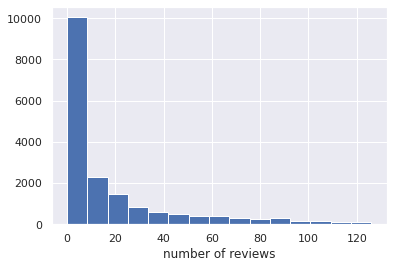

In [426]:
sns.set(rc={'figure.figsize':(6,4)}) 
plt.hist(Y_prueba, bins=15)
plt.xlabel("number of reviews")

Escalando los datos

In [427]:
scaler = StandardScaler()

In [428]:
X_entrena_escalado = scaler.fit_transform(X_entrena)
X_prueba_escalado = scaler.transform(X_prueba)

In [429]:
X_entrena_escalado.shape

(72111, 8)

# **Entrenando el modelo**

In [430]:
regr = LinearRegression()

Valores imputados

In [500]:
num_prepro_pipeline = Pipeline(steps = [('imputar', SimpleImputer(strategy='median')),  ('scalar', MinMaxScaler(feature_range=(1, 2))), ('sqrt', FunctionTransformer(np.sqrt))]) 

In [501]:
regr.fit(X_entrena_escalado, X_prueba_escalado)

ValueError: ignored

**Transformating Data**